In [6]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
# !pip install keras
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 21.5 MB/s eta 0:00:00 0:00:01
Using cached joblib-1.4.2-py3-none-any.w

In [7]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("train.csv")

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: >

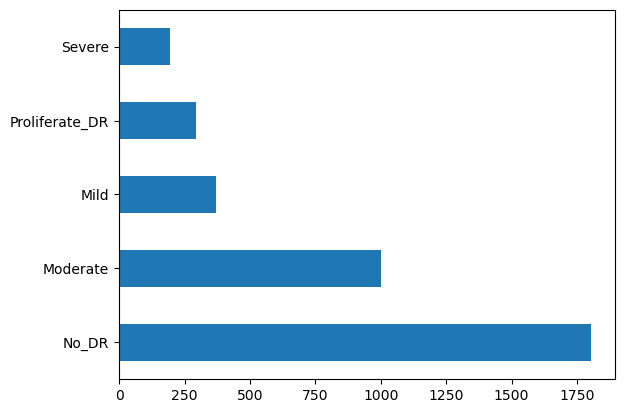

In [5]:
df['type'].value_counts().plot(kind='barh')

In [6]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

For Testing Dataset :
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

For Validation Dataset :
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [7]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [8]:
src_dir = 'gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [9]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [15]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=15,
                    validation_data=val_batches)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-14 15:51:19.756214: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 316ms/step - acc: 0.7139 - loss: 0.5955 - val_acc: 0.5073 - val_loss: 0.7753
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - acc: 0.8845 - loss: 0.3032 - val_acc: 0.5073 - val_loss: 0.9175
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 309ms/step - acc: 0.9006 - loss: 0.2766 - val_acc: 0.5073 - val_loss: 1.0320
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/step - acc: 0.9193 - loss: 0.2382 - val_acc: 0.5182 - val_loss: 0.8279
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 309ms/step - acc: 0.9198 - loss: 0.2357 - val_acc: 0.6091 - val_loss: 0.6680
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 314ms/step - acc: 0.9315 - loss: 0.1965 - val_acc: 0.7509 - val_loss: 0.4086
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 310ms/step - acc: 0.9342 - loss: 0.1989 - val_acc: 0.9164 - val_loss: 0.2538
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 310ms/step - acc: 0.9332 - loss: 0.1962 - val_acc: 0.9418 - val_loss: 0.1932
Epoch 9/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/

In [16]:
# model.save('64x3-CNN.model')
model.save('DiabeticRetonipathy_15epochs.h5')

In [18]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - acc: 0.9441 - loss: 0.1694 
Loss:  0.17069515585899353
Accuracy:  0.9436363577842712


In [8]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("DiabeticRetonipathy_15epochs.h5")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('Diabetic Retinopathy Not Detected')
    else:
        print('Diabetic Retinopathy Detected')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Diabetic Retinopathy Not Detected


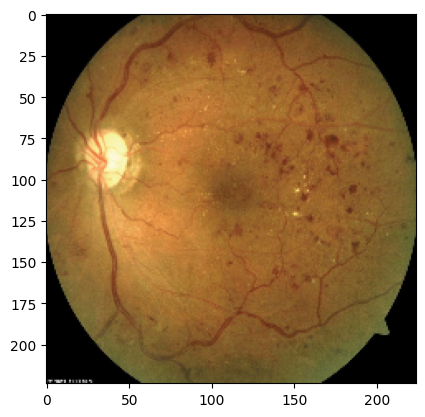

In [10]:
predict_class('retina_apr.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Diabetic Retinopathy Not Detected


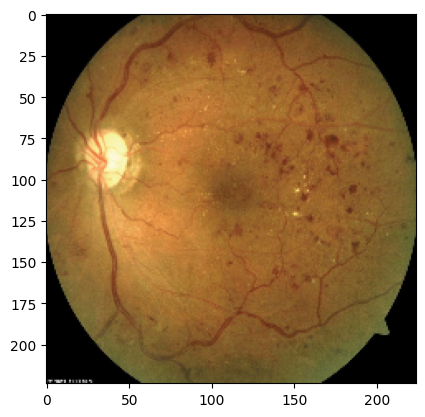

In [11]:
path='retina_apr.png'
# path='gaussian_filtered_images/gaussian_filtered_images/Mild/0a61bddab956.png'
img = cv2.imread(path)
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))
plt.imshow(RGBImg)
image = np.array(RGBImg) / 255.0
new_model = tf.keras.models.load_model("DiabeticRetonipathy_15epochs.h5")
predict=new_model.predict(np.array([RGBImg]))
per=np.argmax(predict,axis=1)
if per==1:
    print('Diabetic Retinopathy Not Detected')
else:
    print('Diabetic Retinopathy Detected')

In [32]:
print(image[0][120])
print(RGBImg[0][120])

[0.41176471 0.26666667 0.10196078]
[105  68  26]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Diabetic Retinopathy Detected


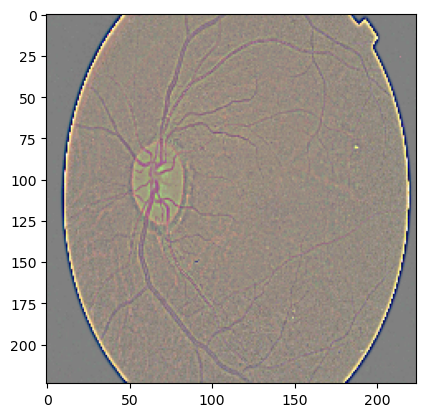

In [12]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Mild/0a61bddab956.png')